In [1]:
import sys
sys.path.append('../..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import ta
import numpy as np
import datetime
from IPython.display import clear_output
from utilities.data_manager import ExchangeDataManager
from utilities.custom_indicators import get_n_columns, SmoothedHeikinAshi
from utilities.bt_analysis import get_metrics, multi_backtest_analysis
from utilities.plot_analysis import plot_equity_vs_asset, plot_futur_simulations, plot_bar_by_month
import nest_asyncio
nest_asyncio.apply()

In [2]:
class Strategy():
    def __init__(
        self,
        pair,
        df,
        type=["long"],
        params={},
    ):
        self.pair = pair
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.params = params

        
    def populate_indicators(self):
        params = self.params
        df = self.df
        df.drop(
            columns=df.columns.difference(['open','high','low','close','volume']), 
            inplace=True
        )
        
        # -- Populate indicators --
        df['fast_ma'] = ta.trend.sma_indicator(close=df["close"], window=params["fast_ma"])
        df['slow_ma'] = ta.trend.sma_indicator(close=df["close"], window=params["slow_ma"])
        df['mrat'] = df['fast_ma'] / df['slow_ma']
        df['signal'] = ta.trend.sma_indicator(close=df['mrat'], window=params["signal"])
    
        self.df = df

        return self.df
    
    def populate_buy_sell(self): 
        params = self.params
        df = self.df
        # -- Initiate populate --
        df["close_long"] = False
        df["close_short"] = False
        df["open_short"] = False
        df["open_long"] = False
            
        if self.use_long:
            df.loc[
                (df['mrat'] >= df['signal'])
                , "open_long"
            ] = True
            
            # -- Populate close long --
            df.loc[
                (df['mrat'] < df['signal'])
                , "close_long"
            ] = True
            
        
        if self.use_short:
            df.loc[
                (df['mrat'] < df['signal'])
                , "open_short"
            ] = True
            
            df.loc[
                (df['mrat'] >= df['signal'])
                , "close_short"
            ] = True
                

        self.df = df
        
        return self.df
        
    def run_backtest(self, initial_wallet=1000, leverage=1):
        params = self.params
        df_ini = self.df[:]
        wallet = initial_wallet
        long_exposition = 0
        short_exposition = 0
        maker_fee = 0.0002
        taker_fee = 0.0006
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None
        
        for index, row in df_ini.iterrows():
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['open']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        close_size = current_position['size'] + current_position['size']  * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - current_position['size'] - fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['open']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        close_size = current_position['size'] + current_position['size']  * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - current_position['size'] - fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['open'],
                    "long_exposition":0,
                    "short_exposition":0,
                    "risk":0,
                })
            previous_day = current_day 
            
            # -- Close LONG --
            # Close Market    
            if current_position and current_position['side'] == "LONG" and row['close_long']:
                close_price = row['close']
                trade_result = (close_price - current_position['price']) / current_position['price']
                close_size = current_position['size'] + current_position['size'] * trade_result
                fee = close_size * maker_fee
                wallet += close_size - current_position['size'] - fee
                trades.append({
                    "pair": self.pair,
                    "open_date": current_position['date'],
                    "close_date": index,
                    "position": current_position['side'],
                    "open_reason": current_position['reason'],
                    "close_reason": "Market",
                    "open_price": current_position['price'],
                    "close_price": close_price,
                    "open_fee": current_position['fee'],
                    "close_fee": fee,
                    "open_trade_size":current_position['size'],
                    "close_trade_size":close_size,
                    "wallet": wallet,
                })
                current_position = None
                
            # -- Close SHORT --
            if current_position and current_position['side'] == "SHORT" and row['close_short']:
                close_price = row['close']
                trade_result = (current_position['price'] - close_price) / current_position['price']
                close_size = current_position['size'] + current_position['size'] * trade_result
                fee = close_size * taker_fee
                wallet += close_size - current_position['size'] - fee
                trades.append({
                    "pair": self.pair,
                    "open_date": current_position['date'],
                    "close_date": index,
                    "position": current_position['side'],
                    "open_reason": current_position['reason'],
                    "close_reason": "Market",
                    "open_price": current_position['price'],
                    "close_price": close_price,
                    "open_fee": current_position['fee'],
                    "close_fee": fee,
                    "open_trade_size":current_position['size'],
                    "close_trade_size":close_size,
                    "wallet": wallet,
                })
                current_position = None
                    
            # -- Check for opening position --
            # -- Open LONG --
            if current_position is None and row['open_long']:
                open_price = row["close"]
                pos_size = (params["size"] * wallet * leverage)
                fee = pos_size * taker_fee
                pos_size -= fee
                wallet -= fee
                current_position = {
                    "size": pos_size,
                    "date": index,
                    "price": open_price,
                    "fee":fee,
                    "reason": "Market",
                    "side": "LONG",
                }
            # -- Open SHORT --
            if current_position is None and row['open_short']:
                open_price = row["close"]
                pos_size = (params["size"] * wallet * leverage)
                fee = pos_size * taker_fee
                pos_size -= fee
                wallet -= fee
                current_position = {
                    "size": pos_size,
                    "date": index,
                    "price": open_price,
                    "fee":fee,
                    "reason": "Market",
                    "side": "SHORT",
                }             
                        
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }      

In [3]:
params = {
    "fast_ma": 10,
    "slow_ma": 100,
    "signal": 20,
    "size": 1,
}

pair_list = list(params.keys())
exchange_name = "binance"
tf = '4h'
pair = "ETH/USDT"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df = exchange.load_data(pair, tf)

print("Data load 100%")

Data load 100%


In [12]:
strat = Strategy(
    pair=pair,
    df=df,
    type=["long",],
    params=params,
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)

df_trades, df_days = multi_backtest_analysis(
    trades=bt_result['trades'], 
    days=bt_result['days'],
    general_info=True,
    trades_info=True,
    days_info=True,
    long_short_info=True,
    entry_exit_info=True,
    exposition_info=False,
    pair_info=True,
    indepedant_trade=True
)

╒═════════════════════════════════╤══════════════════════════╕
│ Informations générales          │                          │
╞═════════════════════════════════╪══════════════════════════╡
│ Période                         │ 06.09.2017 -> 17.02.2024 │
│ Portefeuille initial            │ 1,000.00 $  (levier x1)  │
│                                 │                          │
│ Portefeuille final              │ 44,606.63 $              │
│ Performance vs US dollar        │ 4,360.66 %               │
│ Pire Drawdown T|D               │ -49.04 % | -51.54 %      │
│ Moyenne journalière Drawdown    │ -17.34 %                 │
│ Buy and hold performance        │ 794.32 %                 │
│ Performance vs buy and hold     │ 398.78 %                 │
│ Nombre total de trades          │ 293                      │
│ Sharpe | Sortino | Calmar Ratio │ 1.29 | 1.71 | 1.47       │
│ Global Win rate                 │ 43.0 %                   │
│ Profit moyen                    │ 1.78 %             

In [5]:
# df_trades.to_excel("trades.xlsx")
df_trades

,pair,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,trade_result,trade_result_pct,trade_result_pct_wallet,trades_duration,wallet_ath,drawdown,drawdown_pct
open_date,,,,,,,,,,,,,,,,,,,,
2017-09-06 16:00:00,ETH/USDT,2017-09-06 16:00:00,2017-09-09 00:00:00,LONG,Market,Market,335.00,292.31,0.600000,0.174409,999.400000,872.043624,871.869215,-127.956376,-0.128033,-0.172005,2 days 08:00:00,871.869215,0.000000,0.000000
2017-09-12 04:00:00,ETH/USDT,2017-09-12 04:00:00,2017-09-13 12:00:00,LONG,Market,Market,314.15,266.93,0.523122,0.148075,871.346094,740.373747,740.225673,-131.495468,-0.150911,-0.216016,1 days 08:00:00,871.869215,131.643542,0.150990
2017-09-16 20:00:00,ETH/USDT,2017-09-16 20:00:00,2017-09-21 20:00:00,LONG,Market,Market,249.31,257.00,0.444135,0.152520,739.781537,762.600197,762.447677,22.374524,0.030245,0.028509,5 days 00:00:00,871.869215,109.421538,0.125502
2017-09-23 20:00:00,ETH/USDT,2017-09-23 20:00:00,2017-09-29 16:00:00,LONG,Market,Market,285.93,292.81,0.457469,0.156065,761.990208,780.325090,780.169025,17.877413,0.023461,0.022401,5 days 20:00:00,871.869215,91.700191,0.105177
2017-10-06 12:00:00,ETH/USDT,2017-10-06 12:00:00,2017-10-09 12:00:00,LONG,Market,Market,301.67,300.01,0.468101,0.155082,779.700923,775.410462,775.255380,-4.758563,-0.006103,-0.006176,3 days 00:00:00,871.869215,96.613836,0.110812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21 04:00:00,ETH/USDT,2023-12-21 04:00:00,2023-12-25 20:00:00,LONG,Market,Market,2215.11,2271.35,23.141922,7.905080,38546.728816,39525.401672,39517.496591,955.530933,0.024789,0.023609,4 days 16:00:00,40451.952440,934.455848,0.023100
2023-12-27 20:00:00,ETH/USDT,2023-12-27 20:00:00,2023-12-30 08:00:00,LONG,Market,Market,2378.35,2288.14,23.710498,7.599160,39493.786093,37995.800329,37988.201169,-1521.696263,-0.038530,-0.041729,2 days 12:00:00,40451.952440,2463.751271,0.060906
2024-01-02 04:00:00,ETH/USDT,2024-01-02 04:00:00,2024-01-03 20:00:00,LONG,Market,Market,2385.84,2209.72,22.792921,7.032569,37965.408248,35162.844916,35155.812347,-2825.356253,-0.074419,-0.087390,1 days 16:00:00,40451.952440,5296.140093,0.130924


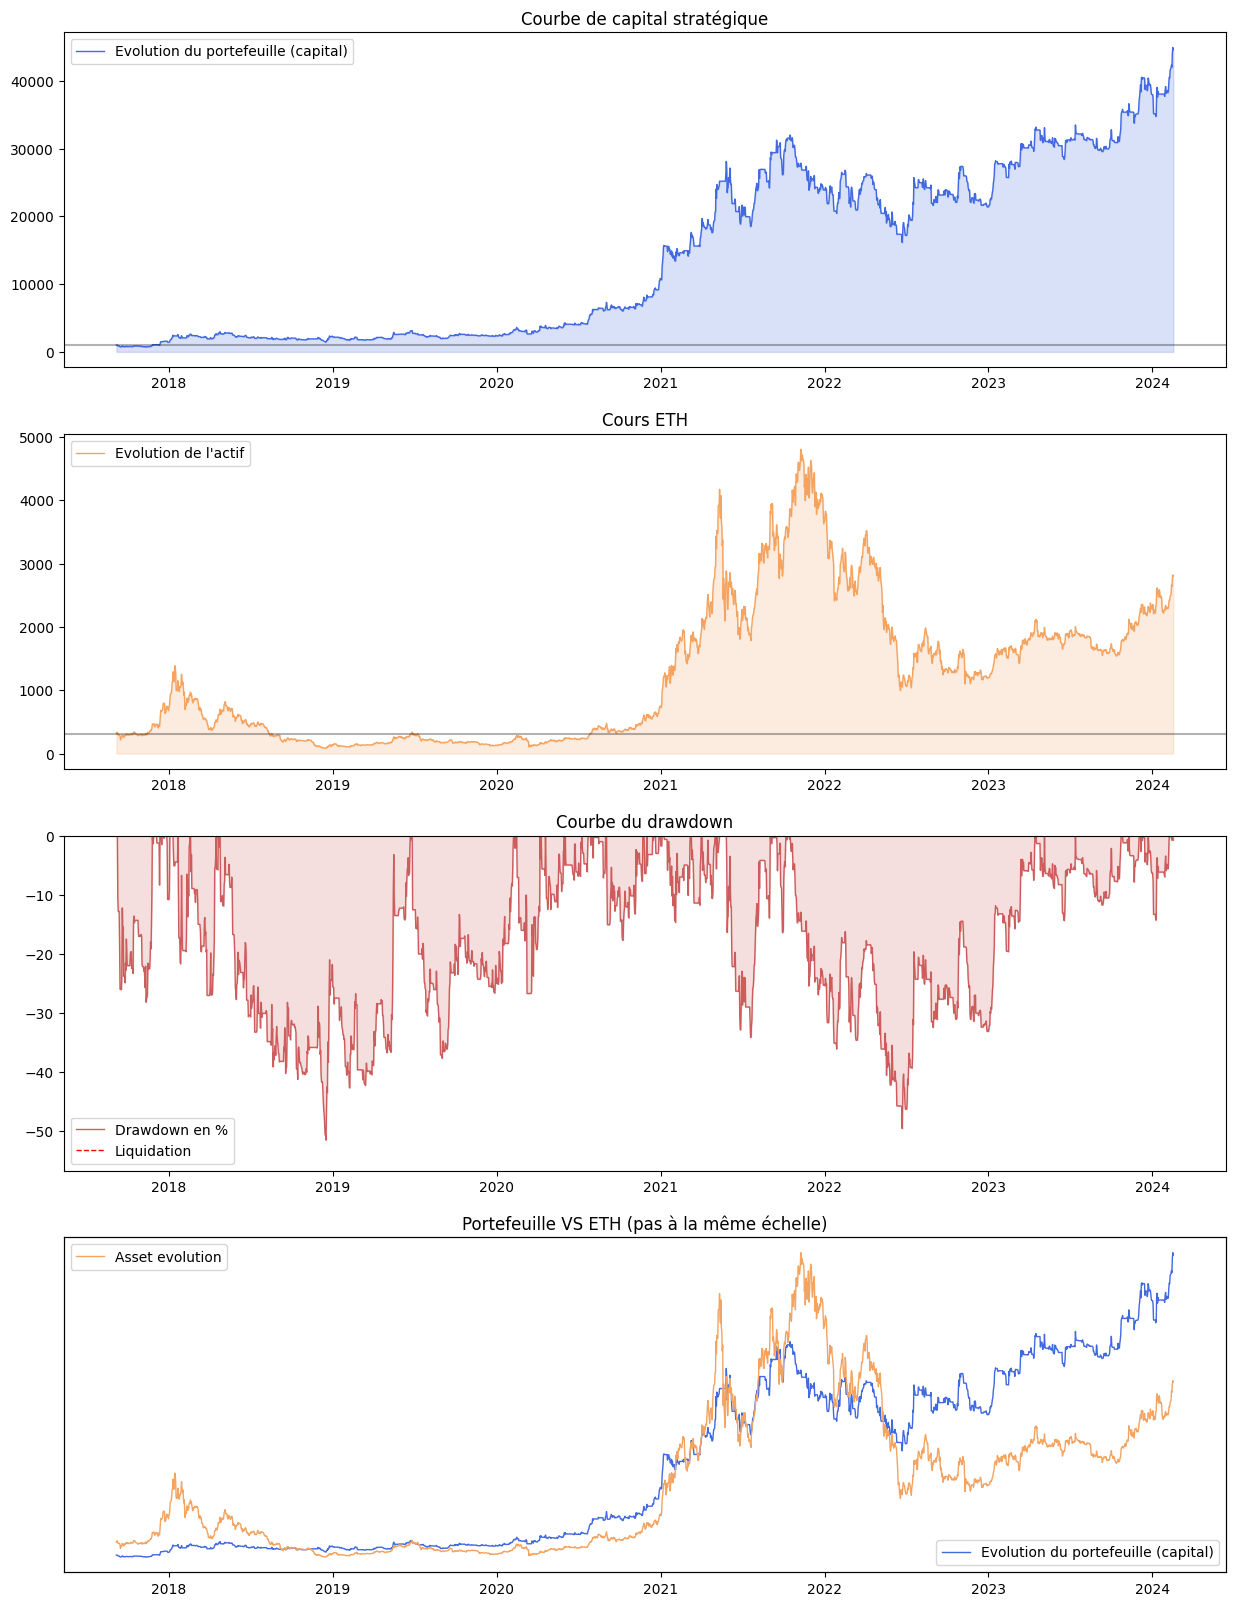

In [7]:
plot_equity_vs_asset(df_days=df_days.loc[:], pair=pair)

----- 2017 Cumulative Performances: 42.06% -----


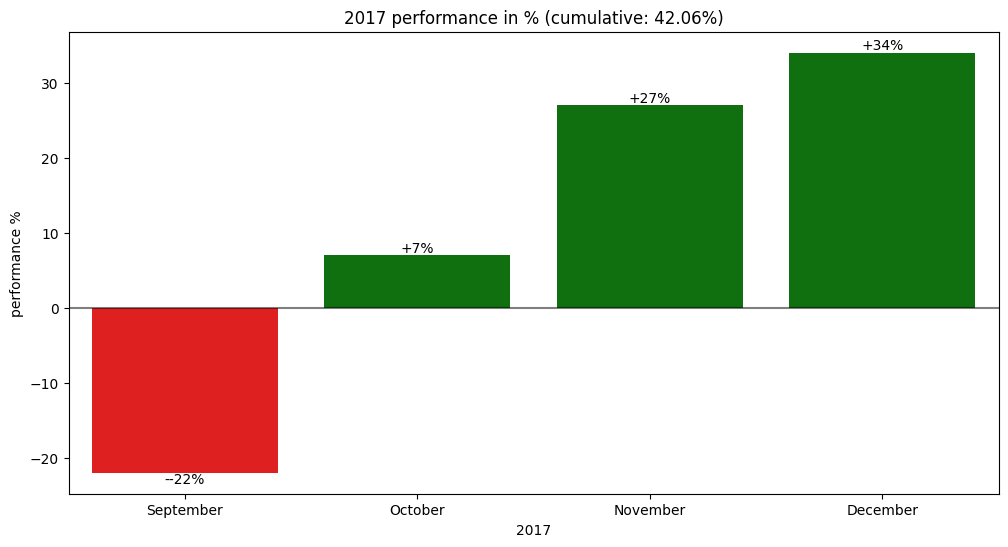

----- 2018 Cumulative Performances: 63.94% -----


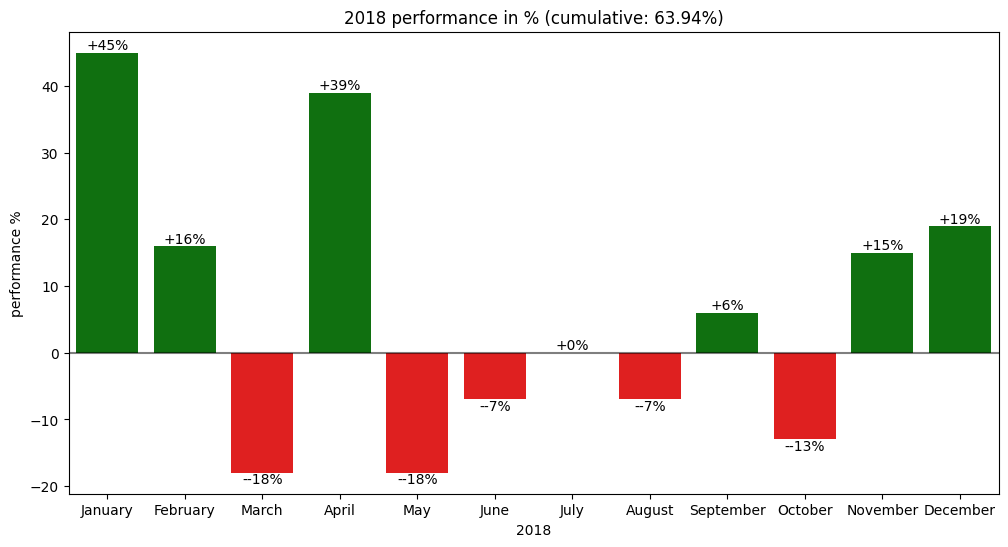

----- 2019 Cumulative Performances: 7.96% -----


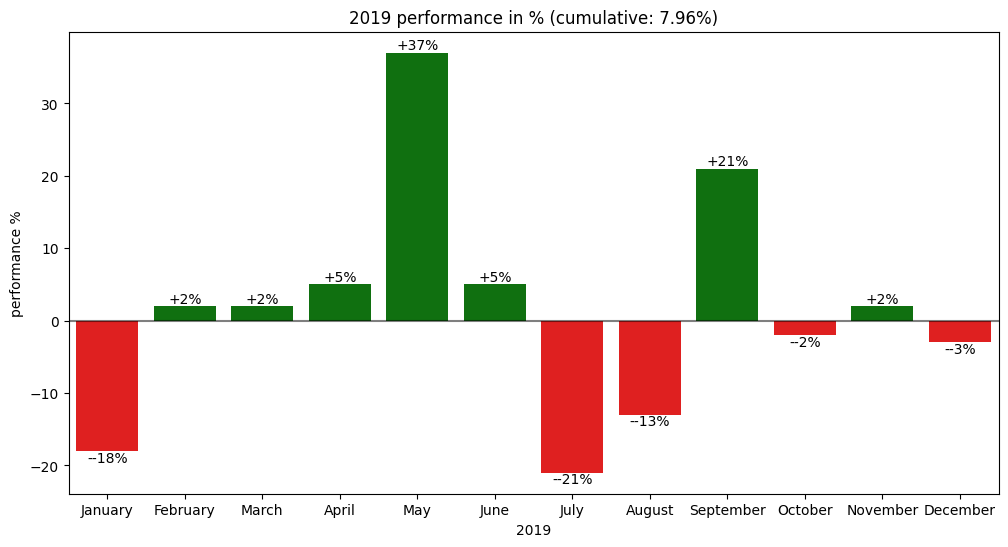

----- 2020 Cumulative Performances: 362.12% -----


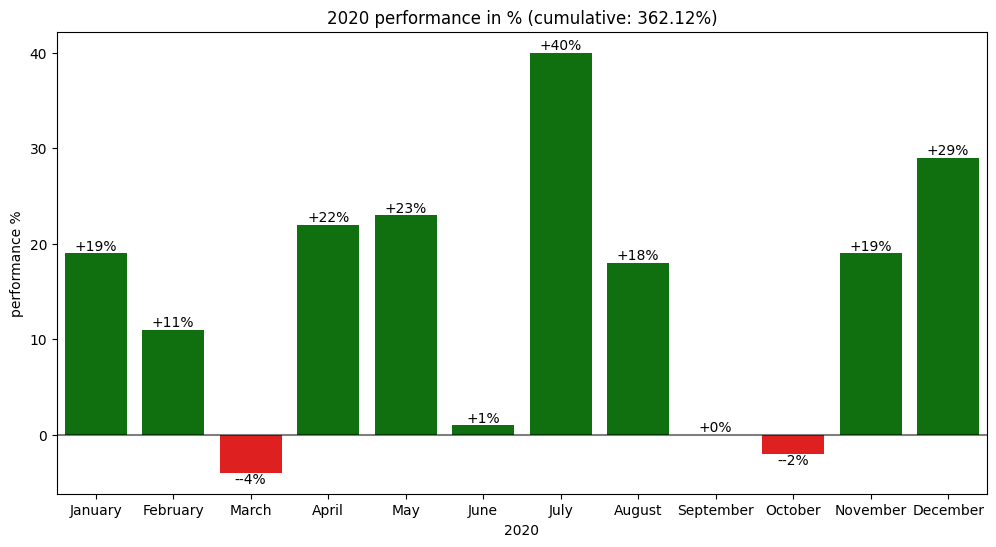

----- 2021 Cumulative Performances: 124.39% -----


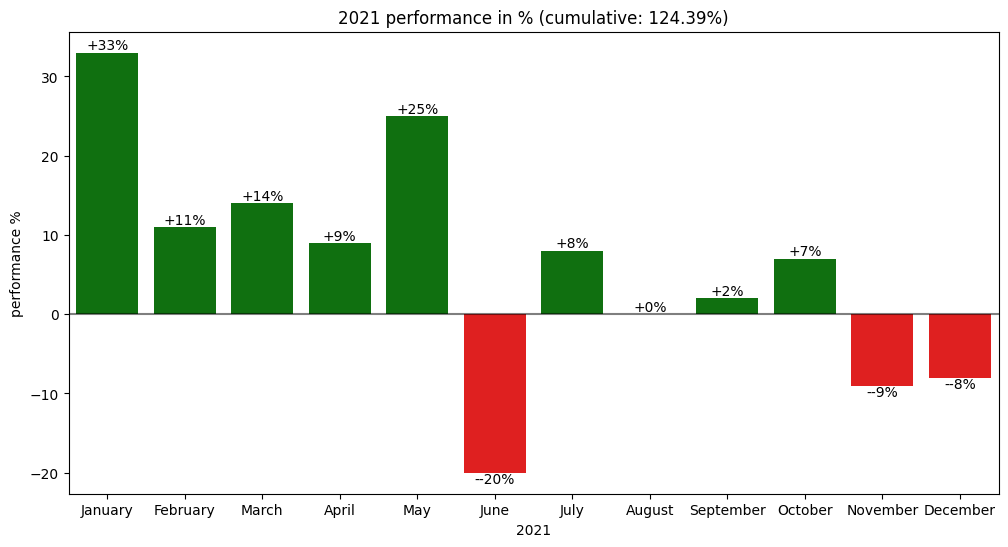

----- 2022 Cumulative Performances: -10.21% -----


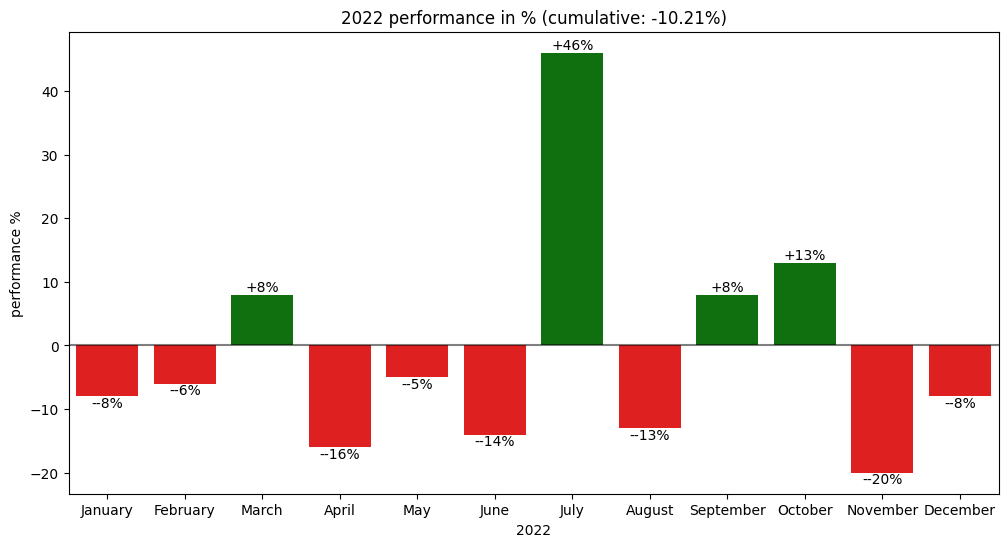

----- 2023 Cumulative Performances: 77.47% -----


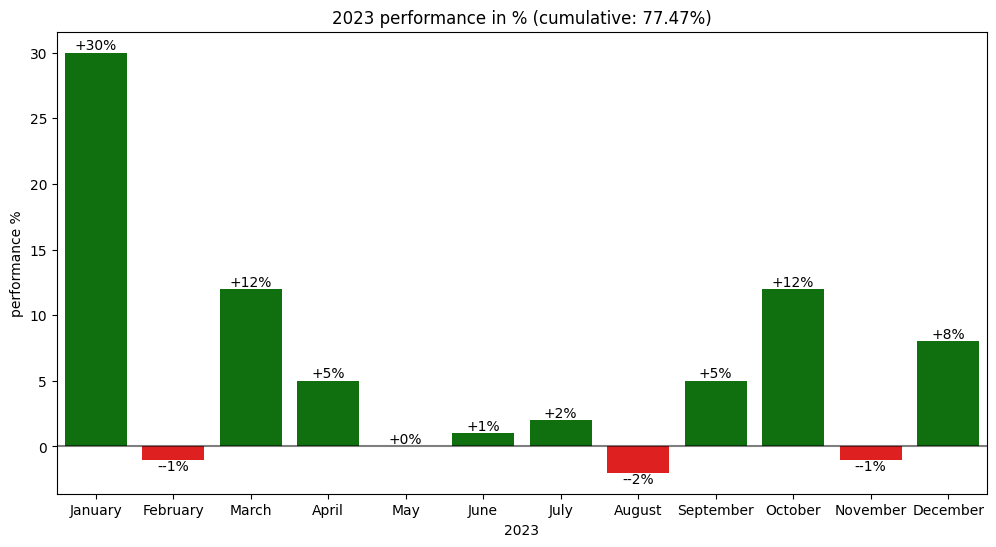

----- 2024 Cumulative Performances: 17.42% -----


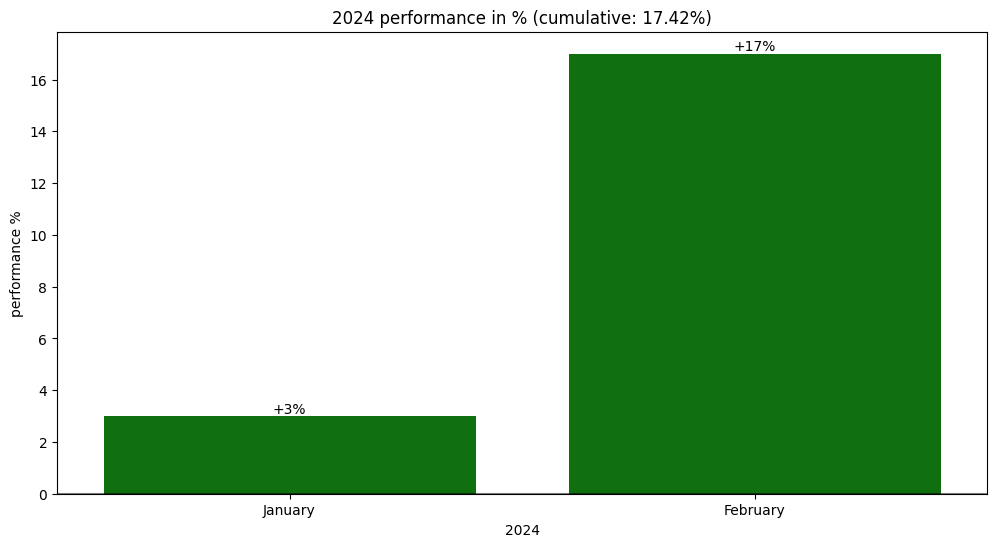

In [8]:
plot_bar_by_month(df_days=df_days)

In [9]:
df_trades.sort_values(by=["trade_result_pct"])

,pair,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,trade_result,trade_result_pct,trade_result_pct_wallet,trades_duration,wallet_ath,drawdown,drawdown_pct
open_date,,,,,,,,,,,,,,,,,,,,
2019-02-24 04:00:00,ETH/USDT,2019-02-24 04:00:00,2019-02-24 16:00:00,LONG,Market,Market,164.17,138.94,1.275600,0.359639,2124.724987,1798.192664,1797.833026,-327.807923,-0.154283,-0.222995,0 days 12:00:00,2883.630260,1085.797235,0.376538
2017-09-12 04:00:00,ETH/USDT,2017-09-12 04:00:00,2017-09-13 12:00:00,LONG,Market,Market,314.15,266.93,0.523122,0.148075,871.346094,740.373747,740.225673,-131.495468,-0.150911,-0.216016,1 days 08:00:00,871.869215,131.643542,0.150990
2017-09-06 16:00:00,ETH/USDT,2017-09-06 16:00:00,2017-09-09 00:00:00,LONG,Market,Market,335.00,292.31,0.600000,0.174409,999.400000,872.043624,871.869215,-127.956376,-0.128033,-0.172005,2 days 08:00:00,871.869215,0.000000,0.000000
2020-03-02 12:00:00,ETH/USDT,2020-03-02 12:00:00,2020-03-08 20:00:00,LONG,Market,Market,228.36,199.43,1.815528,0.528192,3024.065255,2640.958722,2640.430531,-384.922061,-0.127286,-0.170659,6 days 08:00:00,3348.424013,707.993482,0.211441
2019-06-26 08:00:00,ETH/USDT,2019-06-26 08:00:00,2019-06-27 20:00:00,LONG,Market,Market,340.79,298.35,1.876961,0.547410,3126.391035,2737.048521,2736.501111,-391.219475,-0.125135,-0.166811,1 days 12:00:00,3128.267996,391.766885,0.125234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-10 20:00:00,ETH/USDT,2019-05-10 20:00:00,2019-05-18 04:00:00,LONG,Market,Market,172.91,236.07,1.132849,0.515242,1886.949005,2576.207574,2575.692333,688.125720,0.364676,0.210835,7 days 08:00:00,2883.630260,307.937927,0.106788
2021-01-03 08:00:00,ETH/USDT,2021-01-03 08:00:00,2021-01-08 20:00:00,LONG,Market,Market,829.76,1216.93,6.394630,3.124256,10651.321677,15621.279513,15618.155257,4963.563206,0.466004,0.241164,5 days 12:00:00,15618.155257,0.000000,0.000000
2017-12-11 16:00:00,ETH/USDT,2017-12-11 16:00:00,2017-12-16 08:00:00,LONG,Market,Market,470.98,691.13,0.620404,0.303284,1033.385562,1516.420577,1516.117293,482.414612,0.466829,0.241384,4 days 16:00:00,1516.117293,0.000000,0.000000
